In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
ens_method = "rand_init"
ens_method_ls = [
    "rand_init",
    "bagging",
    "batchensemble",
    "bayesian",
    "mc_dropout",
    "concrete_dropout",
    "variational_dropout",
]
ens_method_labels = {
    "rand_init": "Naive",
    "bagging": "Bagging",
    "batchensemble": "BatchEns.",
    "bayesian": "Bayesian",
    "mc_dropout": "MC Drop.",
    "concrete_dropout": "Conc. Drop.",
    "variational_dropout": "Var. Drop.",
}
dataset_ls = [
    "scen_1",
    "scen_4",
    "boston",
    "concrete",
    "energy",
    "kin8nm",
    "naval",
    "power",
    "protein",
    "wine",
    "yacht",
]
dataset_labels = {
    "scen_1": "Scenario 1 \n (N=16,000)",
    "scen_4": "Scenario 2 \n (N=16,000)",
    "boston": "Boston Housing \n (N=506)",
    "concrete": "Concrete Strength \n (N=1,030)",
    "energy": "Energy Efficiency \n (N=768)",
    "kin8nm": "Kin8nm \n (N=8,192)",
    "naval": "Naval Propulsion \n (N=11,934)",
    "power": "Power Plant \n (N=9,568)",
    "protein": "Protein Structure \n (N=45,730)",
    "wine": "Red Wine Quality \n (N=1,599)",
    "yacht": "Yacht\n Hydrodynamics \n (N=308)"
}

In [3]:
# Get colors
agg_cols = sns.color_palette("Dark2", 8, as_cmap=True)
# Colors of aggregation methods
agg_col = {
    "lp": agg_cols.colors[4],  # type: ignore
    "vi": agg_cols.colors[5],  # type: ignore
    "vi-a": agg_cols.colors[2],  # type: ignore
    "vi-w": agg_cols.colors[0],  # type: ignore
    "vi-aw": agg_cols.colors[3],  # type: ignore
    "ens": agg_cols.colors[7],  # type: ignore
    "opt": agg_cols.colors[1],  # type: ignore
}

greens = sns.color_palette("Greens", 2, as_cmap=False)
blues = sns.color_palette("Blues", 1)
purples = sns.color_palette("Purples", 1)
reds = sns.color_palette("Reds", 3)
ens_col = {
    "rand_init": greens[1], #multi_model_cols.colors[0],  # type: ignore
    "bagging": greens[0], #multi_model_cols.colors[1],  # type: ignore
    "batchensemble": blues[0], #multi_model_cols.colors[3],  # type: ignore
    "bayesian": purples[0], #multi_model_cols.colors[8],  # type: ignore
    "mc_dropout": reds[2], #dropout_cols.colors[14],  # type: ignore
    "variational_dropout": reds[1], #dropout_cols.colors[16],  # type: ignore
    "concrete_dropout": reds[0], #dropout_cols.colors[15],  # type: ignore
}

# KIT colors
kit_cols_dict = {
    "green": "#00876C",
    "blue": "#4664AA",
    "black": "#000000",
    "grey": "#404040",
}

In [4]:
score_vec = ["crps", "crpss", "me", "lgt", "cov", "a", "w"]
nn_vec = ["drn", "bqn"]
n_ens_vec = np.arange(start=2, stop=10 + 2, step=2)
agg_meths = ["lp", "vi", "vi-a", "vi-w", "vi-aw"]

In [5]:
export = True
save_dir = os.path.join("plots", "results")

# Get runtime for training and prediction

In [6]:
data_path = os.path.join("..", "..", "04_Experiments", f"Normal_final")

In [7]:
# dataset_ls = ["wine", "naval"]

In [8]:
df_final = pd.DataFrame()

for dataset in dataset_ls:
    for ens_method in ens_method_ls:
        dir_path = os.path.join(data_path, dataset, ens_method)
        filename = f"runtime_{dataset}_{ens_method}.pkl"
        with open(os.path.join(data_path, filename), "rb") as f:
            df_runtime = pickle.load(f)
        df_runtime["ens_method"] = ens_method
        
        df_final = pd.concat(
            [
                df_final,
                pd.DataFrame(df_runtime),
            ],
            ignore_index=True,
        )

df_final["runtime_train_s"] = df_final["runtime_train"] / 1e+9
df_final["runtime_pred_s"] = df_final["runtime_pred"] / 1e+9


In [13]:
df_final.groupby("ens_method")["runtime_pred_s"].mean()

ens_method
bagging                 0.993316
batchensemble           3.631245
bayesian                9.657610
concrete_dropout        8.423286
mc_dropout             10.589096
rand_init               0.629998
variational_dropout     7.125709
Name: runtime_pred_s, dtype: float64

In [9]:
df_final[(df_final["dataset"].isin(["boston", "concrete", "energy", "kin8nm", "naval", "power", "protein", "yacht"])) & (df_final["ens_method"].isin(["bayesian", "concrete_dropout", "variational_dropout"]))]["runtime_pred_s"].mean()

8.336521717023546

In [58]:
print(f"Mean BatchE vs. Naive/Bagging: {19.457612249054296 / 9.171184850565067 -1: .4f}")
print(f"Variational vs. Concrete dropout: {18.460163351 / 8.090761834 -1: .4f}")
print(f"Variational vs. MC dropout: {25.358235823303566 / 33.80808804604534 -1: .4f}")

Mean BatchE vs. Naive/Bagging:  1.1216
Variational vs. Concrete dropout:  1.2816
Variational vs. MC dropout: -0.2499


In [43]:
df_matrix = pd.DataFrame(columns=["dataset", "nn", *ens_method_ls])

for dataset in dataset_ls:
    for nn in nn_vec:
        row = {
            "dataset": dataset,
            "nn": nn,
            **df_final[(df_final["dataset"] == dataset) & (df_final["nn"] == nn)].groupby("ens_method")["runtime_pred_s"].median()
        }
        
        df_matrix = pd.concat(
            [
                df_matrix,
                pd.DataFrame(row, index=[0]),
            ],
            ignore_index=True
        )
        

In [44]:
df_matrix
# df_matrix["bays-rand"] = df_matrix["bayesian"] / df_matrix["rand_init"]
# df_matrix["bays-bagg"] = df_matrix["bayesian"] / df_matrix["bagging"]
# df_matrix["mc-conc"] = df_matrix["concrete_dropout"] / df_matrix["mc_dropout"]
# df_matrix["conc_var"] = df_matrix["variational_dropout"] / df_matrix["concrete_dropout"]


# df_matrix.describe()

,dataset,nn,rand_init,bagging,batchensemble,bayesian,mc_dropout,concrete_dropout,variational_dropout
0,scen_1,drn,0.595885,0.595459,9.808310,9.511650,9.852284,10.233994,9.270084
1,scen_1,bqn,0.602689,0.599952,8.644625,10.122488,10.216812,10.967657,9.929848
2,scen_4,drn,0.609706,0.689672,9.798775,9.649136,9.821506,10.081400,9.367846
3,scen_4,bqn,0.611959,0.667635,8.482021,10.392562,10.324910,10.944649,10.095921
4,boston,drn,0.126496,0.125754,1.498617,5.397303,5.319344,5.676689,5.259003
5,boston,bqn,0.126607,0.125674,1.469654,5.502843,5.356270,5.769305,5.260577
6,concrete,drn,0.136807,0.136569,1.602950,5.417552,5.313513,6.238692,5.260467
7,concrete,bqn,0.136103,0.135749,1.605586,5.505809,5.455545,6.155655,5.266088
8,energy,drn,0.128731,0.134636,1.893578,7.552108,5.333612,11.088684,5.446688
9,energy,bqn,0.129491,0.132803,2.018733,7.528308,5.517594,10.100856,5.396847


Text(0.5, 0.9, 'Model runtime in seconds (training and prediction)')

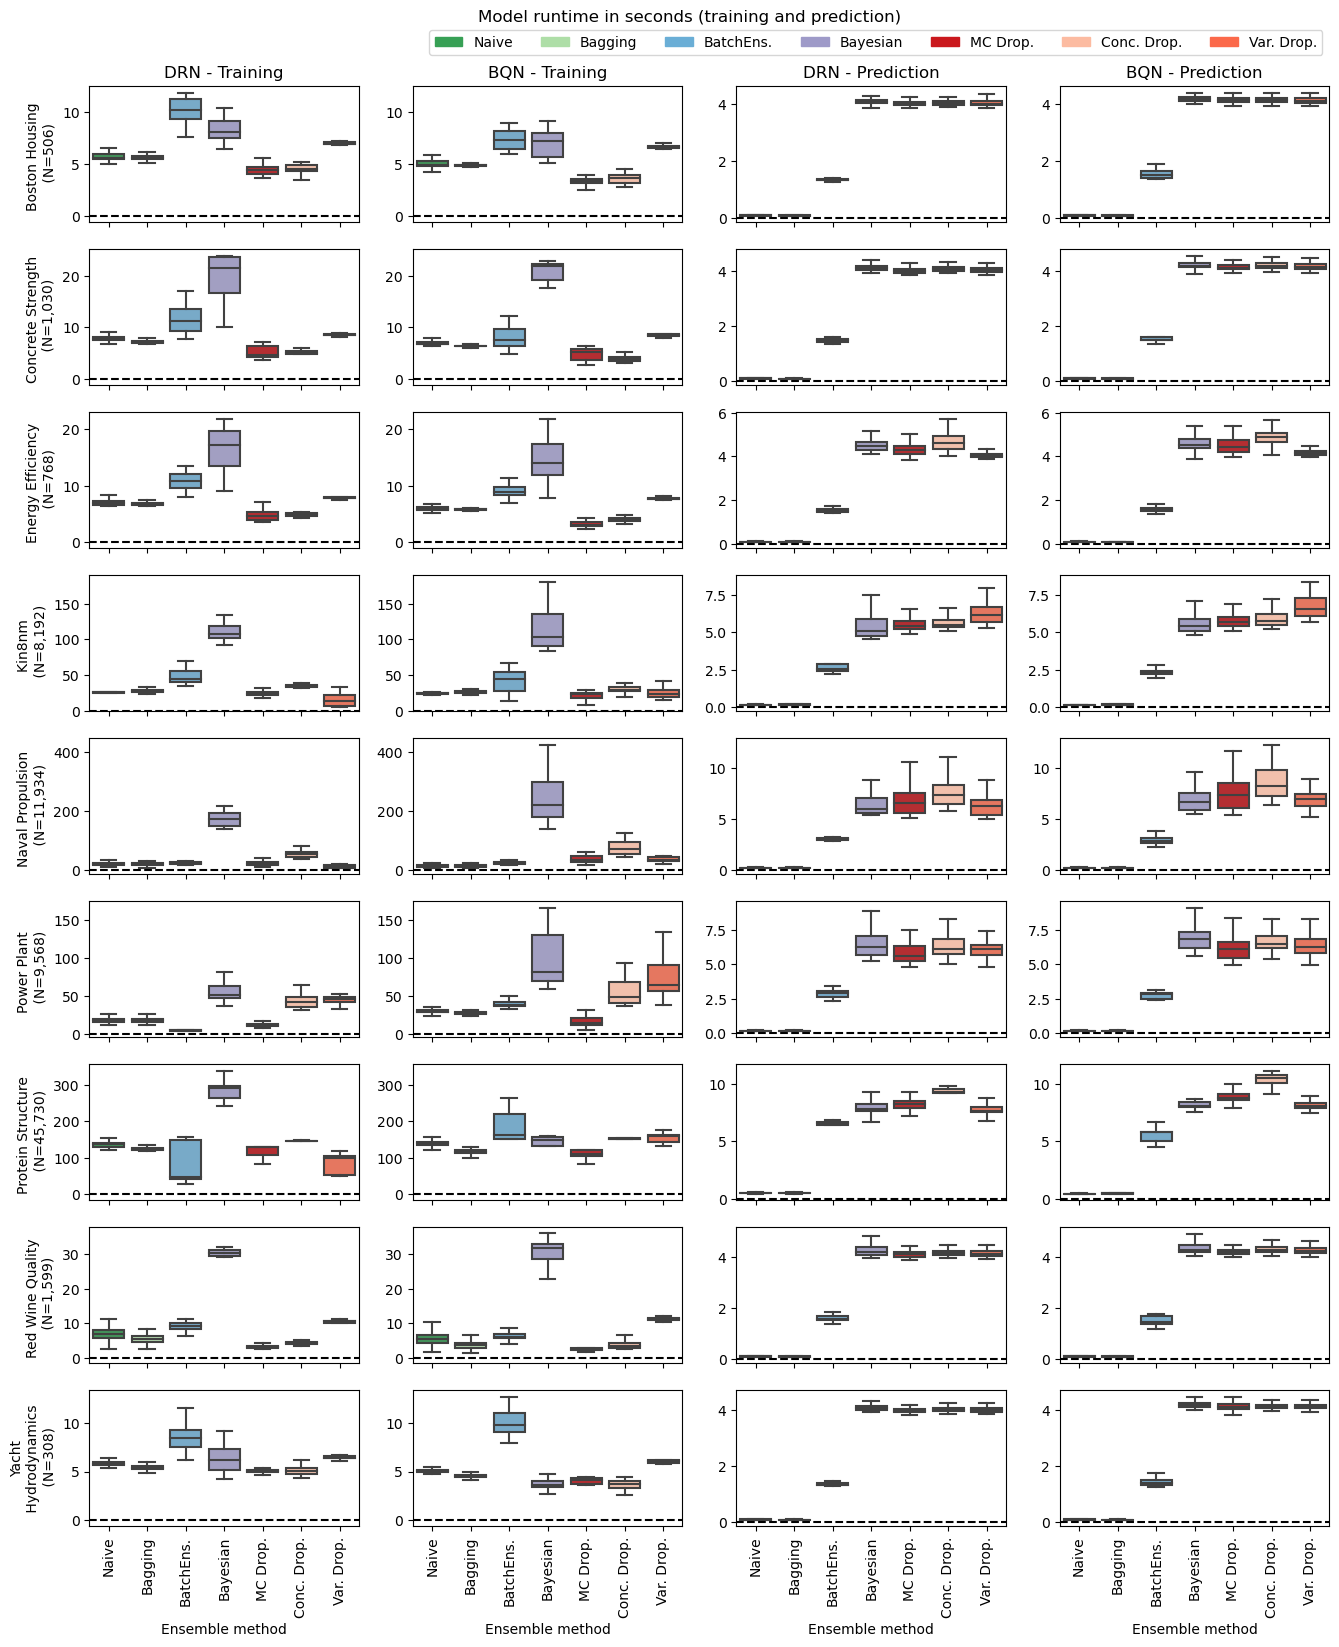

In [16]:
##### Skill - Boxplots - x=aggregation_methods #####

# Temp:
nn_vec = df_final["nn"].unique()

# Create subplots
fig, axs = plt.subplots(nrows=len(dataset_ls), ncols=len(nn_vec)*2, figsize=(16,16*1.2), squeeze=False)

# Iterate over NN types and datasets
for i_nn, nn in enumerate(nn_vec):
    df_nn = df_final[df_final["nn"] == nn]
    for i_dataset, dataset in enumerate(dataset_ls):
        df_nn_dataset = df_nn[(df_nn["dataset"] == dataset)]
        
        #### Train runtime ####                
        # Plot boxplots
        f = sns.boxplot(ax=axs[i_dataset][i_nn], data=df_nn_dataset, y="runtime_train_s", x="ens_method", showfliers=False, color=kit_cols_dict["green"], palette=ens_col, order=ens_method_ls)
        g = sns.boxplot(ax=axs[i_dataset][len(nn_vec)+i_nn], data=df_nn_dataset, y="runtime_pred_s", x="ens_method", showfliers=False, color=kit_cols_dict["green"], palette=ens_col, order=ens_method_ls)
        
        # Add 0 line
        f.axhline(0, linestyle="--", color=kit_cols_dict["black"])
        g.axhline(0, linestyle="--", color=kit_cols_dict["black"])
        # Add labels to x and y axis
        axs[i_dataset][i_nn].set_ylabel("")
        axs[i_dataset][len(nn_vec)+i_nn].set_ylabel("")
        axs[i_dataset][0].set_ylabel(dataset_labels[dataset])
        if i_dataset == len(dataset_ls)-1:
            axs[i_dataset][i_nn].set_xticklabels([ens_method_labels.get(ens_method) for ens_method in ens_method_ls], rotation=90)
            axs[i_dataset][len(nn_vec)+i_nn].set_xticklabels([ens_method_labels.get(ens_method) for ens_method in ens_method_ls], rotation=90)
            axs[i_dataset][i_nn].set_xlabel("Ensemble method")
            axs[i_dataset][len(nn_vec)+i_nn].set_xlabel("Ensemble method")
        else:
            axs[i_dataset][i_nn].tick_params(axis="x", which="both", top=False, labelbottom=False)
            axs[i_dataset][len(nn_vec)+i_nn].tick_params(axis="x", which="both", top=False, labelbottom=False)
            axs[i_dataset][i_nn].set_xlabel("")
            axs[i_dataset][len(nn_vec)+i_nn].set_xlabel("")
        # Set titles
        axs[0][i_nn].set_title(f"{nn.upper()} - Training")
        axs[0][len(nn_vec)+i_nn].set_title(f"{nn.upper()} - Prediction")


# # Remove subplot legends and add figure legend
for ax in [item for sublist in axs for item in sublist]:
    ax.legend([],[], frameon=False)
handles = []
handles = [matplotlib.patches.Patch(color=ens_col.get(ens_method)) for ens_method in ens_method_ls]  # type: ignore
labels = [ens_method_labels.get(ens_method) for ens_method in ens_method_ls]


# Set y axis range
for ax_drn_train, ax_bqn_train, ax_drn_pred, ax_bqn_pred in axs:
    train_l = min(ax_drn_train.get_ylim()[0], ax_bqn_train.get_ylim()[0])
    train_u = max(ax_drn_train.get_ylim()[1], ax_bqn_train.get_ylim()[1])
    pred_l = min(ax_drn_pred.get_ylim()[0], ax_bqn_pred.get_ylim()[0])
    pred_u = max(ax_drn_pred.get_ylim()[1], ax_bqn_pred.get_ylim()[1])
        
    ax_drn_train.set_ylim(train_l, train_u)
    ax_bqn_train.set_ylim(train_l, train_u)
    ax_drn_pred.set_ylim(pred_l, pred_u)
    ax_bqn_pred.set_ylim(pred_l, pred_u)

# Set titles and legends
fig.subplots_adjust(top=0.86)
fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.893), ncol=len(ens_method_ls))
fig.suptitle(f"Model runtime in seconds (training and prediction)", y=0.9)

# Save figure
# if export:
#     filename=os.path.join(save_dir, "05_runtime_boxplot.pdf")
#     fig.savefig(filename, bbox_inches='tight')
#     filename=os.path.join(save_dir, "05_runtime_boxplot.png")
#     fig.savefig(filename, bbox_inches='tight')